In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import xbudget
import regionate
import xwmt
import xwmb
import xgcm
import cartopy.crs as ccrs
import CM4Xutils #needed to run: pip install nc-time-axis
from regionate import MaskRegions, GriddedRegion
import seaborn as sns
import sys
import matplotlib.ticker as mticker

sys.path.insert(0, '/vortexfs1/home/anthony.meza/scratch/CM4XTransientTracers/src')
from src import *
sns.set_style("whitegrid")
sns.set_context("notebook")

In [3]:
print('xgcm version', xgcm.__version__, '\nregionate version', regionate.__version__, '\nxwmt version', xwmt.__version__, '\nxwmb version', xwmb.__version__)

xgcm version 0.8.2.dev15+g7492277 
regionate version 0.1.1 
xwmt version 0.3.0 
xwmb version 0.2.1


In [4]:
import sectionate
print(f"Sectionate version: {sectionate.__version__}")

Sectionate version: 0.2.1


In [5]:
from Streamfunctions import *
from Streamfunctions_Sectionate import *

rho0 = 1035. # kg/m3
Sv_s_per_m3 = 1e-6
Sv_s_per_kg = Sv_s_per_m3/rho0

In [6]:
def get_transports(ds):
    return ds[["umo", "vmo", "sigma2_i", "thkcello"]]

In [27]:
datadir = lambda x="" : "/vortexfs1/home/anthony.meza/CM4Xp25/" + x
ds = xr.open_mfdataset(
        # datadir("CM4Xp125_budgets_sigma2_2000-2004.zarr"),
        datadir("CM4Xp25_budgets_sigma2_1945-1949.zarr"),
        data_vars="minimal",
        coords="minimal",
        compat="override",
        parallel=True,
        # preprocess = get_transports, 
        engine="zarr")

z_i = np.arange(-6500, 251, 50)
z_l = (z_i[1:] + z_i[0:-1]) / 2
ds = ds.assign_coords({"z_l": z_l, "z_i":z_i})

In [34]:
grid = CM4Xutils.ds_to_grid(ds, Zprefix = "sigma2")


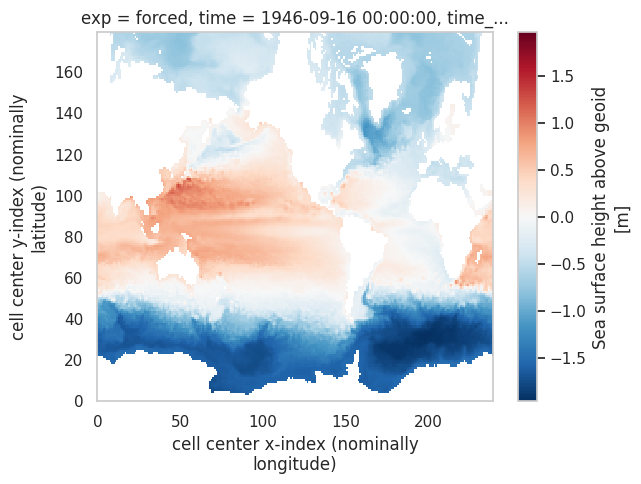

In [47]:
grid._ds.zos.isel(exp = 0, time = 20).plot()

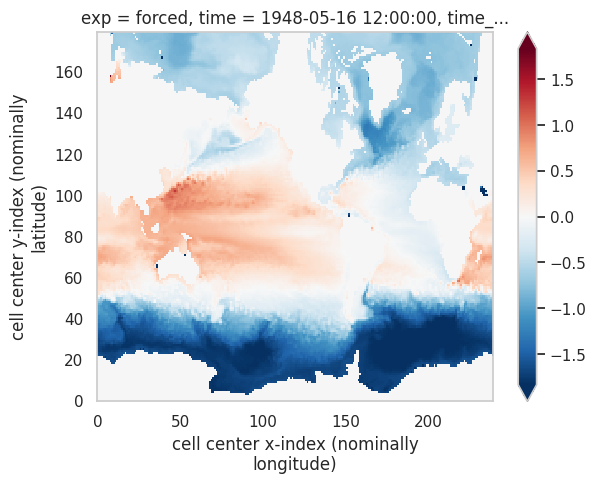

In [48]:
(grid._ds.thkcello.isel(exp = 0, time = 40).sum("sigma2_l") - grid._ds.deptho).plot(robust = True)

In [19]:
#following https://mpas-dev.github.io/MPAS-Tools/0.29.0/_modules/mpas_tools/ocean/depth.html#compute_depth

In [37]:
bottomDepth = ds["deptho"].compute()
thickness = ds["thkcello"]
wet = ds["wet"].compute()
thicknessSum = thickness.sum(dim="sigma2_l")
zSurface = thicknessSum - bottomDepth

/tmp/ipykernel_182329/1553215599.py:8: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm1  = ax[0].pcolormesh(ds["geolon"], ds["geolat"],
/tmp/ipykernel_182329/1553215599.py:13: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  ax[1].pcolormesh(ds["geolon"], ds["geolat"],
/tmp/ipykernel_182329/1553215599.py:19: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  cm = ax[2].pcolormesh(ds["ge

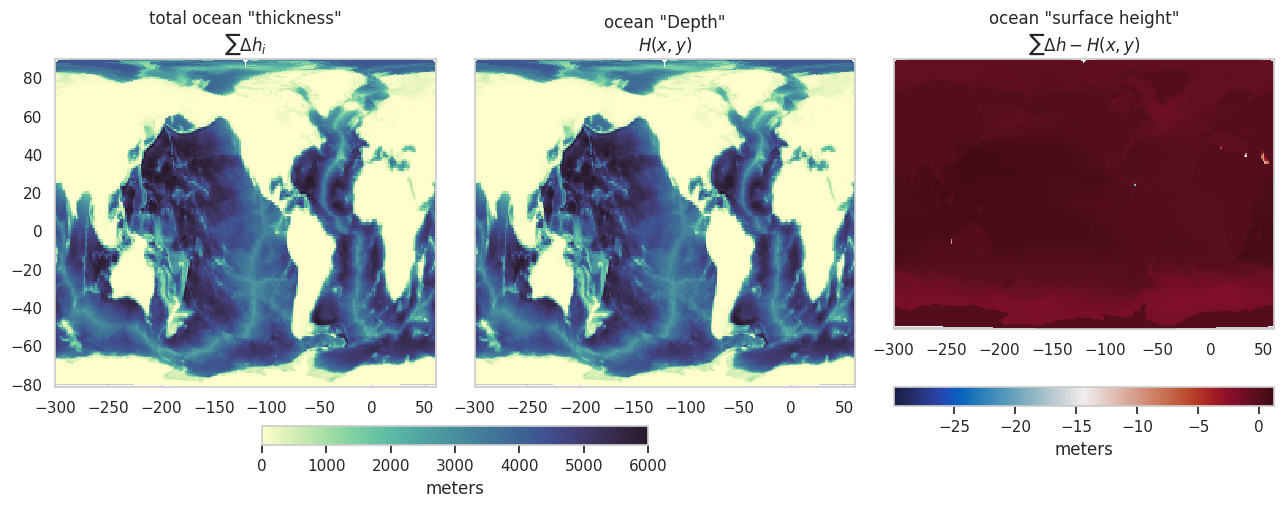

In [38]:
import cmocean.cm as cmo
fig, ax = plt.subplots(1, 3, figsize = (13, 5), sharey = True)

depth_cmap = cmo.deep

diff_cmap = cmo.balance
ax[0].set_title('total ocean "thickness"\n' + r"$\sum \Delta h_i$")
cm1  = ax[0].pcolormesh(ds["geolon"], ds["geolat"], 
                 thicknessSum.mean("time").isel(exp = 0).compute(), 
                cmap = depth_cmap, vmin = 0, vmax = 6000)

ax[1].set_title('ocean "Depth"\n' + r"$H(x, y)$")
ax[1].pcolormesh(ds["geolon"], ds["geolat"], 
                 bottomDepth.compute(), 
                 cmap = depth_cmap, vmin = 0, vmax = 6000)


ax[2].set_title('ocean "surface height"\n' + r"$\sum \Delta h - H(x, y)$")
cm = ax[2].pcolormesh(ds["geolon"], ds["geolat"], 
                 zSurface.mean("time").isel(exp = 0).compute(), 
                cmap = diff_cmap)

fig.tight_layout()

fig.colorbar(cm1, ax = ax[0:2], label = "meters", orientation = "horizontal", 
             fraction = 0.05, pad = 0.1)
fig.colorbar(cm, ax = ax[[2]], label = "meters", orientation = "horizontal")